# Compare results to Global Methane Assessment

...who showed a 0.2C decrease from an implied 30% reduction in methane. This is a poorly put together notebook, sorry. I didn't have the same time I had for the others.

- run fair concentration-driven (never a great idea)
- expt1: fix GHG concentrations and SLCFs at 2015 levels, run to equilibrium
- expt2: halve methane and set other SLCFs to 2050 levels (check exact spec in https://www.unep.org/resources/report/global-methane-assessment-benefits-and-costs-mitigating-methane-emissions)

the concentration driven setup will be based on the AR6 GitHub at https://github.com/chrisroadmap/ar6/blob/main/notebooks/190_WG3_run-constrained-fair-ensemble-concentration-driven.ipynb

In [1]:
from copy import copy
import json
import platform

from climateforcing.utils import mkdir_p
from fair.forward import fair_scm
import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
with open('../data_input/fair-1.6.2-ar6/fair-1.6.2-wg3-params.json') as f:
    config_list = json.load(f)

In [3]:
conc_all = pd.read_csv('../data_input/rcmip/rcmip-concentrations-annual-means-world-ssp370-v5-1-0.csv')
emis_all = pd.read_csv('../data_input/rcmip/rcmip-emissions-annual-means-world-ssp370-v5-1-0.csv')

results_out = {}

In [4]:
nt = 361

In [5]:
expt = 'ssp370'
results_out[expt] = {}
emis_subset = emis_all[(emis_all['Scenario']==expt)&(emis_all['Region']=='World')]
species=['CO2|MAGICC Fossil and Industrial','CO2|MAGICC AFOLU','CH4','N2O','Sulfur','CO','VOC','NOx','BC','|OC','NH3',
         'CF4','C2F6','C6F14','HFC23','HFC32','HFC4310mee','HFC125','HFC134a','HFC143a',
         'HFC227ea','HFC245fa','SF6','CFC11','CFC12','CFC113','CFC114','CFC115','CCl4','CH3CCl3','HCFC22',
         'HCFC141b','HCFC142b','Halon1211','Halon1202','Halon1301','Halon2402','CH3Br','|CH3Cl']
emis = np.zeros((nt, 40))
emis[:,0] = np.arange(1750, 2111)
for ie, specie in enumerate(species):
    try:
        temp = emis_subset[emis_subset.Variable.str.endswith(specie)].loc[:,'1750':'2110'].values.squeeze()
        emis[:,ie+1] = pd.Series(temp).interpolate().values
    except:
        emis[:,ie+1] = 0
temp = emis_subset[emis_subset['Variable']=='Emissions|NOx|MAGICC Fossil and Industrial|Aircraft'].loc[:,'1750':'2500'].values.squeeze()
aviNOx = pd.Series(temp).interpolate().values
aviNOx_frac = aviNOx[:nt]/emis[:,8]

unit_convert = np.ones(40)
unit_convert[1]=0.001 * 12/44
unit_convert[2]=0.001 * 12/44
unit_convert[4]=0.001 * 28/44
unit_convert[5]=32/64
unit_convert[8]=14/46

emis = emis * unit_convert

conc_subset = conc_all[(conc_all['Scenario']==expt)&(conc_all['Region']=='World')]
gases=['CO2','CH4','N2O','CF4','C2F6','C6F14','HFC23','HFC32','HFC4310mee','HFC125','HFC134a','HFC143a',
       'HFC227ea','HFC245fa','SF6','CFC11','CFC12','CFC113','CFC114','CFC115','CCl4','CH3CCl3','HCFC22',
       'HCFC141b','HCFC142b','Halon1211','Halon1202','Halon1301','Halon2402','CH3Br','CH3Cl']
conc = np.zeros((nt, 31))

for ig, gas in enumerate(gases):
    try:
        temp = conc_subset[conc_subset.Variable.str.endswith(gas)].loc[:,'1750':'2110'].values.squeeze()
        conc[:,ig] = pd.Series(temp).interpolate().values
    except:
        conc[:,ig] = 0
        
def run_fair(args):
        nt = len(emis)
        F_solar = np.zeros(nt)
        F_volcanic = np.zeros(nt)
        
        C,F,T,ariaci, lambda_eff, ohc, heatflux = fair_scm(
            emissions=emis,
            emissions_driven=False,
            C_pi = conc[0,:],
            C = conc,
            natural=np.zeros((nt,2)),
            F_volcanic=F_volcanic,#np.mean(F_volcanic),
            F_solar=F_solar,
            F2x=args['F2x'],
            ariaci_out=True,
            ghg_forcing='Meinshausen',
            scale=np.asarray(args['scale']),
            aerosol_forcing='aerocom+ghan2',
            b_aero = np.asarray(args['b_aero']),
            ghan_params=np.asarray(args['ghan_params']),
            tropO3_forcing='thorhnill+skeie',
            ozone_feedback=args['ozone_feedback'],
            b_tro3 = np.array(args['b_tro3']),
            E_pi=emis[0,:],
            scaleAerosolAR5=False,
            scaleHistoricalAR5=False,
            fixPre1850RCP=False,
            aviNOx_frac=0,
            aCO2land = args['aCO2land'],
            stwv_from_ch4 = args['stwv_from_ch4'],
            F_ref_BC = args['F_ref_BC'],
            E_ref_BC = args['E_ref_BC'],
            efficacy=np.ones(45),
            diagnostics='AR6',
            temperature_function='Geoffroy',
            lambda_global = args['lambda_global'],  # this and the below only used in two-layer model
            deep_ocean_efficacy = args['deep_ocean_efficacy'],
            ocean_heat_capacity = np.asarray(args['ocean_heat_capacity']),
            ocean_heat_exchange = args['ocean_heat_exchange'],
        )

        nt = len(T)

        return(T-T[100:151].mean(), np.sum(F, axis=1))

    
if platform.system() == 'Windows':
    shape = (nt, len(config_list))
    results_out[expt]['temperature'] = np.ones(shape) * np.nan
    results_out[expt]['effective_radiative_forcing'] = np.ones(shape) * np.nan
    for i, cfg in tqdm(enumerate(config_list[:len(config_list)]), total=len(config_list[:len(config_list)]), position=0, leave=True):
        results_out['ssp370']['temperature'][:,i], results_out['ssp370']['effective_radiative_forcing'][:,i] = run_fair(config_list[i])

100%|██████████████████████████████████████████████████████████████████████████████| 2237/2237 [02:05<00:00, 17.84it/s]


In [6]:
# constant 2015 GHG conc / SLCF emis
# can't quite tell what assumption is for GHGs: SSP3 or constant 2015?
expt = 'c1'
results_out[expt] = {}
emis_c1 = copy(emis)
emis_c1[265:,5:12] = emis_c1[265:266,5:12]
aviNOx_frac_c1 = copy(aviNOx_frac[:nt])
aviNOx_frac_c1[265:] = aviNOx_frac[265]
emis_c1 = emis_c1 * unit_convert

conc_c1 = copy(conc)
conc_c1[265:,:] = conc_c1[265:266,:]
        
def run_fair(args):
        nt = len(emis)
        F_solar = np.zeros(nt)
        F_volcanic = np.zeros(nt)
        
        C,F,T,ariaci, lambda_eff, ohc, heatflux = fair_scm(
            emissions=emis_c1,
            emissions_driven=False,
            C_pi = conc_c1[0,:],
            C = conc_c1,
            natural=np.zeros((nt,2)),
            F_volcanic=F_volcanic,#np.mean(F_volcanic),
            F_solar=F_solar,
            F2x=args['F2x'],
            ariaci_out=True,
            ghg_forcing='Meinshausen',
            scale=np.asarray(args['scale']),
            aerosol_forcing='aerocom+ghan2',
            b_aero = np.asarray(args['b_aero']),
            ghan_params=np.asarray(args['ghan_params']),
            tropO3_forcing='thorhnill+skeie',
            ozone_feedback=args['ozone_feedback'],
            b_tro3 = np.array(args['b_tro3']),
            E_pi=emis_c1[0,:],
            scaleAerosolAR5=False,
            scaleHistoricalAR5=False,
            fixPre1850RCP=False,
            aviNOx_frac=0,
            aCO2land = args['aCO2land'],
            stwv_from_ch4 = args['stwv_from_ch4'],
            F_ref_BC = args['F_ref_BC'],
            E_ref_BC = args['E_ref_BC'],
            efficacy=np.ones(45),
            diagnostics='AR6',
            temperature_function='Geoffroy',
            lambda_global = args['lambda_global'],  # this and the below only used in two-layer model
            deep_ocean_efficacy = args['deep_ocean_efficacy'],
            ocean_heat_capacity = np.asarray(args['ocean_heat_capacity']),
            ocean_heat_exchange = args['ocean_heat_exchange'],
        )

        nt = len(T)

        return(T-T[100:151].mean(), np.sum(F, axis=1))

    
if platform.system() == 'Windows':
    shape = (nt, len(config_list))
    results_out[expt]['temperature'] = np.ones(shape) * np.nan
    results_out[expt]['effective_radiative_forcing'] = np.ones(shape) * np.nan
    for i, cfg in tqdm(enumerate(config_list[:len(config_list)]), total=len(config_list[:len(config_list)]), position=0, leave=True):
        results_out[expt]['temperature'][:,i], results_out[expt]['effective_radiative_forcing'][:,i] = run_fair(config_list[i])

100%|██████████████████████████████████████████████████████████████████████████████| 2237/2237 [02:05<00:00, 17.78it/s]


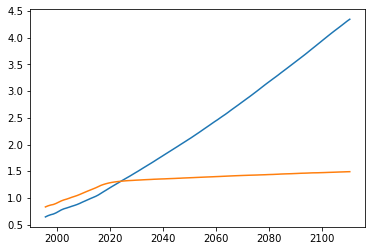

In [9]:
print(conc_c1[265,1])

1841.932699


In [10]:
# constant 2015 GHG conc / SLCF emis with CH4 conc reduced
expt = 'c2'
results_out[expt] = {}
emis_c2 = copy(emis)
emis_c2[265:,5:12] = emis_c2[265:266,5:12]
aviNOx_frac_c2 = copy(aviNOx_frac[:nt])
aviNOx_frac_c2[265:] = aviNOx_frac[265]
emis_c2 = emis_c2 * unit_convert

conc_c2 = copy(conc)
conc_c2[265:,:] = conc_c2[265:266,:]
conc_c2[265:,1] = 1278
        
def run_fair(args):
        nt = len(emis)
        F_solar = np.zeros(nt)
        F_volcanic = np.zeros(nt)
        
        C,F,T,ariaci, lambda_eff, ohc, heatflux = fair_scm(
            emissions=emis_c2,
            emissions_driven=False,
            C_pi = conc_c2[0,:],
            C = conc_c2,
            natural=np.zeros((nt,2)),
            F_volcanic=F_volcanic,#np.mean(F_volcanic),
            F_solar=F_solar,
            F2x=args['F2x'],
            ariaci_out=True,
            ghg_forcing='Meinshausen',
            scale=np.asarray(args['scale']),
            aerosol_forcing='aerocom+ghan2',
            b_aero = np.asarray(args['b_aero']),
            ghan_params=np.asarray(args['ghan_params']),
            tropO3_forcing='thorhnill+skeie',
            ozone_feedback=args['ozone_feedback'],
            b_tro3 = np.array(args['b_tro3']),
            E_pi=emis_c2[0,:],
            scaleAerosolAR5=False,
            scaleHistoricalAR5=False,
            fixPre1850RCP=False,
            aviNOx_frac=0,
            aCO2land = args['aCO2land'],
            stwv_from_ch4 = args['stwv_from_ch4'],
            F_ref_BC = args['F_ref_BC'],
            E_ref_BC = args['E_ref_BC'],
            efficacy=np.ones(45),
            diagnostics='AR6',
            temperature_function='Geoffroy',
            lambda_global = args['lambda_global'],  # this and the below only used in two-layer model
            deep_ocean_efficacy = args['deep_ocean_efficacy'],
            ocean_heat_capacity = np.asarray(args['ocean_heat_capacity']),
            ocean_heat_exchange = args['ocean_heat_exchange'],
        )

        nt = len(T)

        return(T-T[100:151].mean(), np.sum(F, axis=1))

    
if platform.system() == 'Windows':
    shape = (nt, len(config_list))
    results_out[expt]['temperature'] = np.ones(shape) * np.nan
    results_out[expt]['effective_radiative_forcing'] = np.ones(shape) * np.nan
    for i, cfg in tqdm(enumerate(config_list[:len(config_list)]), total=len(config_list[:len(config_list)]), position=0, leave=True):
        results_out[expt]['temperature'][:,i], results_out[expt]['effective_radiative_forcing'][:,i] = run_fair(config_list[i])

100%|██████████████████████████████████████████████████████████████████████████████| 2237/2237 [02:05<00:00, 17.78it/s]


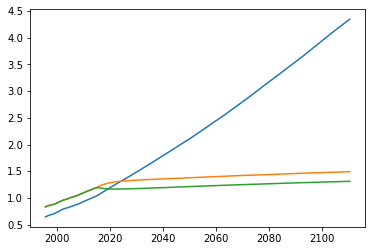

In [11]:
pl.plot(np.arange(1995.5, 2111), np.median(results_out['ssp370']['temperature'][245:,:], axis=1))
pl.plot(np.arange(1995.5, 2111), np.median(results_out['c1']['temperature'][245:,:], axis=1))
pl.plot(np.arange(1995.5, 2111), np.median(results_out['c2']['temperature'][245:,:], axis=1))

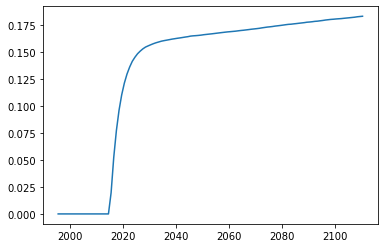

In [12]:
pl.plot(
    np.arange(1995.5, 2111), 
    np.median(
        results_out['c1']['temperature'][245:,:]-results_out['c2']['temperature'][245:,:], axis=1
    )
)

In [19]:
np.median(
    results_out['c1']['temperature'][245:,:]-results_out['c2']['temperature'][245:,:], axis=1
)[30:60].mean()

0.16138649417568104